<a href="https://colab.research.google.com/github/malcolmlett/robovac/blob/main/Experiment_SLAM_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Experiment: SLAM (v2)
The first version was a bit of a mission to get to something working and it had so many side experiments. I now want to move forward with a clean baseline in order to make those improvements.

Here I'll focus on improving the loss functions and possibly tweak the data representations if needed.

I want to get to a point where the model trains as well as can be reasonable given the quality of the dataset.

In [ ]:
import os
if os.path.isdir('repo'):
  # discard any local changes and update
  !cd repo && git reset --hard HEAD
  !cd repo && git fetch
else:
  !git clone https://github.com/malcolmlett/robovac.git repo

# lock to revision
!cd repo && git checkout e33eb2b
#!cd repo && git pull

import sys
sys.path.append('repo')

from general_utils import display_history
import lds
import slam
import slam_data
from importlib import reload
reload(lds)
reload(slam)
reload(slam_data)

Cloning into 'repo'...
remote: Enumerating objects: 285, done.
remote: Counting objects: 100% (155/155), done.
remote: Compressing objects: 100% (97/97), done.
remote: Total 285 (delta 94), reused 91 (delta 57), pack-reused 130 (from 1)
Receiving objects: 100% (285/285), 18.27 MiB | 15.91 MiB/s, done.
Resolving deltas: 100% (132/132), done.
Already up to date.


<module 'slam_data' from '/content/repo/slam_data.py'>

In [ ]:
!pip install -Uqq ipdb

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from PIL import Image
import io
import os
import shutil
import tarfile
import cv2
import requests
import math
import ipdb
import tqdm
import time
from timeit import default_timer as timer

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 60.2 MB/s eta 0:00:00


## Training data


In [ ]:
# If generated data is available then load that to save time:
train_data = slam_data.load_dataset('repo/data/experimental-slam-training-data1.npz')
slam_data.validate_dataset(train_data)

Loaded:
  input_maps:        (1000, 149, 149, 3)
  lds_maps:          (1000, 149, 149)
  ground_truth_maps: (1000, 149, 149, 3)
  adlos:             (1000, 4)
Dataset loaded from repo/data/experimental-slam-training-data1.npz
Dataset tests passed (1000 entries verified)


In [ ]:
# Alternatively, generate new data
#np.random.seed(0)
#train_data = generate_training_data(floorplan, 1000)
#train_data = slam_data.generate_training_data(floorplan, 1000, sample_types=[1])
#slam_data.validate_dataset(train_data)

In [ ]:
# Uncomment to save dataset
#save_dataset(train_data, 'experimental-slam-training-data1-type1only.npz')

In [ ]:
#slam_data.show_dataset(train_data, 5)

## Model Training

map_shape: (149, 149, 3)
Added final cropping layer: w=11, h=11
Prepared SLAM model
  Map shape:        (149, 149, 3) + padding (11, 11, 0)
  Skip-connections: concat
  Output scaling:   logits
  Inputs:           [<KerasTensor shape=(None, 149, 149, 3), dtype=float32, sparse=None, name=map_input>, <KerasTensor shape=(None, 149, 149), dtype=float32, sparse=None, name=lds_input>]
  Outputs:          [<KerasTensor shape=(None, 149, 149, 3), dtype=float32, sparse=False, name=keras_tensor_51>, <KerasTensor shape=(None, 4), dtype=float32, sparse=False, name=keras_tensor_56>]
Epoch 1/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 85s 1s/step - adlo_output_accept_accuracy: 0.6321 - adlo_output_adlo_loss: 1.3113 - adlo_output_loc_error: 0.1636 - adlo_output_orientation_error: 0.3101 - loss: 2.0668 - map_output_accuracy: 0.6707 - map_output_map_loss: 0.7550
Epoch 2/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 24s 368ms/step - adlo_output_accept_accuracy: 0.7431 - adlo_output_adlo_loss: 0.6133 - adlo_output_loc_error: 0.0835

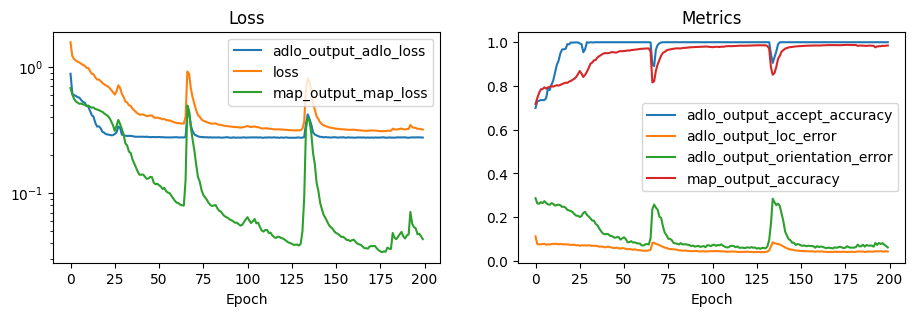

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
adlo:             [1. 0. 0. 0.]
adlo-pred raw:    [ 1.7158768  -0.00886392  0.01309464 -0.00668597]
adlo-pred scaled: [ 0.847597   -0.00443184  0.00654695 -0.00668587]


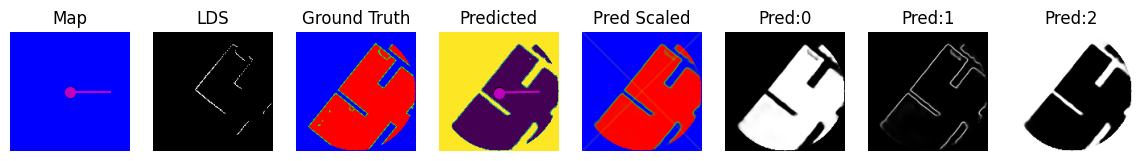

adlo:             [0. 0. 0. 0.]
adlo-pred raw:    [-1.3886049e+00  1.0221871e-03 -6.1468952e-03 -1.5333679e-04]
adlo-pred scaled: [ 1.9963056e-01  5.1109330e-04 -3.0734087e-03 -1.5333679e-04]


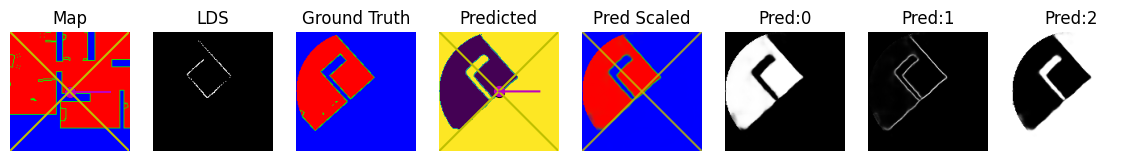

adlo:             [ 1.          0.33607876 -0.16260384  0.29634374]
adlo-pred raw:    [ 1.6923771   0.37815905 -0.21679866  0.29573226]
adlo-pred scaled: [ 0.8445365   0.18055382 -0.10673234  0.2874022 ]


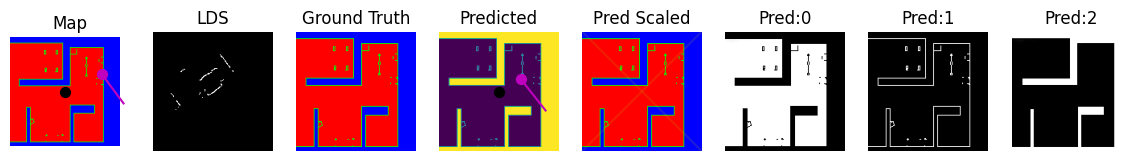

adlo:             [1. 0. 0. 0.]
adlo-pred raw:    [ 1.7127297  -0.02087059  0.00623867  0.00722063]
adlo-pred scaled: [ 0.84719    -0.01043378  0.0031193   0.0072205 ]


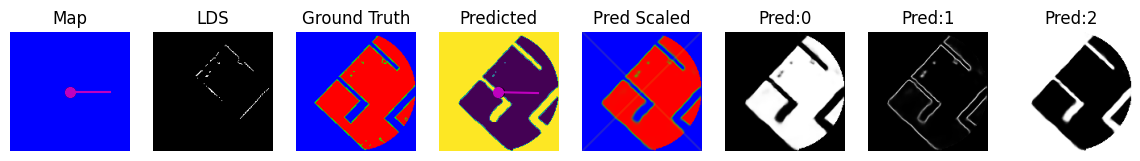

adlo:             [1.         0.17887953 0.22063265 0.16403958]
adlo-pred raw:    [1.725787   0.05792214 0.1726845  0.13799648]
adlo-pred scaled: [0.8488727  0.02892872 0.08549412 0.13712713]


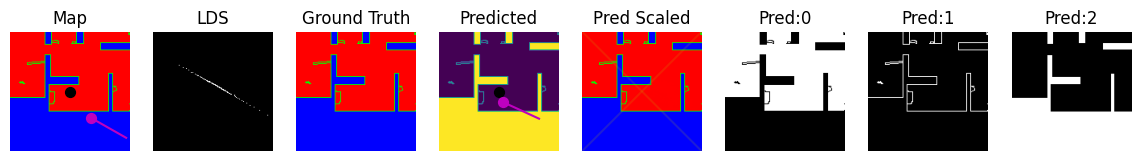

In [ ]:
# Custom loss functions
# (out-of-the-box the two outputs get losses calculated independently,
#  ultimately I'll be wanting to conditionally choose whether the map loss
#  is considered depending on how the network is being used.
#  The easiest way to do that will be to generate the dataset so that the ground_truth_map
#  is blank for those cases)

def adlo_loss(y_true, y_pred):
    """
    y_true: (B,4), scaled
    y_pred: (B,4), logits
    """
    y_true = tf.cast(y_true, tf.float32)

    # binary cross-entropy loss for accept
    accept_true = y_true[:, 0]
    accept_pred = y_pred[:, 0]
    accept_losses = tf.keras.losses.binary_crossentropy(accept_true, accept_pred, from_logits=True)

    # log-cosh loss for delta x, y, orientation
    dlo_true = y_true[:, 1:4]
    delta_x = tf.math.tanh(y_pred[:, 1]) * 0.5  # -0.5 .. +0.5
    delta_y = tf.math.tanh(y_pred[:, 2]) * 0.5  # -0.5 .. +0.5
    delta_angle = tf.math.tanh(y_pred[:, 3])    # -1.0 .. +1.0
    dlo_pred = tf.stack([delta_x, delta_y, delta_angle], axis=1)
    dlo_losses = tf.reduce_mean(tf.math.log(tf.cosh(y_pred - y_true)))

    return accept_losses + dlo_losses

def adlo_loss1(y_true, y_pred):
    """
    y_true: (B,4), scaled
    y_pred: (B,4), logits
    """
    y_true = tf.cast(y_true, tf.float32)
    # scale logits to correct ranges
    accept_true = y_true[:, 0]
    #accept_pred = tf.nn.sigmoid(y_pred[:, 0])

    #accept_pred = tf.nn.sigmoid(y_pred[:, 0])
    #losses = tf.keras.losses.MSE(accept_true, accept_pred)
    #losses = tf.keras.losses.binary_crossentropy(accept_true, accept_pred, from_logits=False)
    print(f"y_true: {y_true.shape}, y_pred: {y_pred.shape}")

    #accept_pred = y_pred[:, 0]
    accept_pred = tf.gather(y_pred, 0, axis=1)

    losses = tf.keras.losses.binary_crossentropy(accept_true, accept_pred, from_logits=True)
    #print(f"accept_true: {accept_true.shape}, accept_pred: {accept_pred.shape}, losses: {losses.shape}")
    #print(f"accept_true ({accept_true.dtype}): {accept_true[0:10]}")
    #print(f"accept_pred ({accept_pred.dtype}): {accept_pred[0:10]}")
    #print(f"accept_pred: {tf.nn.sigmoid(accept_pred[0:10])}")
    #print(f"losses:     ({losses.dtype}) {losses}")

    #lg = tf.math.log(tf.nn.sigmoid(accept_pred))
    #bce = -tf.multiply(accept_true, tf.math.log(tf.nn.sigmoid(accept_pred))) - tf.multiply(1-accept_true, tf.math.log(1-tf.nn.sigmoid(accept_pred)))
    #print(f"log:         {lg[0:10]}")
    #print(f"derivation:  {tf.reduce_mean(bce)} <- {bce[0:10]}")

    return tf.reduce_mean(losses)

def accept_accuracy(y_true, y_pred):
    accept_true = tf.cast(y_true[:, 0], tf.float32)
    accept_pred = tf.cast(tf.round(tf.nn.sigmoid(y_pred[:, 0])), tf.float32)
    matches = tf.equal(accept_true, accept_pred)
    return tf.reduce_mean(tf.cast(matches, tf.float32))

def loc_error(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    loc_true = y_true[:, 1:3]
    loc_pred = tf.math.tanh(y_pred[:, 1:3]) * 0.5  # -0.5 .. +0.5
    losses = tf.math.sqrt(tf.keras.losses.MSE(loc_true, loc_pred))
    return tf.reduce_mean(losses)

def orientation_error(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    angle_true = y_true[:, 3]
    angle_pred = tf.math.tanh(y_pred[:, 3])  # -1.0 .. +1.0
    losses = tf.math.sqrt(tf.keras.losses.MSE(angle_true, angle_pred))
    return tf.reduce_mean(losses)

reload(slam)
reload(slam_data)
one = next(iter(train_data))
map_shape = one[0][0].shape
print(f"map_shape: {map_shape}")
np.random.seed(42)
tf.random.set_seed(42)

model = slam.slam_model(map_shape, conv_filters=32, adlo_units=256)
model.compile(optimizer='adam',
              #run_eagerly=True,
              loss={
                  'map_output': tf.keras.losses.CategoricalCrossentropy(from_logits=True),
                  'adlo_output': adlo_loss
              },
              metrics={
                  'map_output': [tf.keras.metrics.CategoricalCrossentropy(from_logits=True, name='map_loss'), 'accuracy'],
                  'adlo_output': [adlo_loss, accept_accuracy, loc_error, orientation_error]
              })

epochs = 200
batch_size = 32
model_train_data = train_data.shuffle(buffer_size=len(train_data)).batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)

start = timer()
model_history = model.fit(model_train_data, epochs=epochs)
duration = (timer() - start)
print(f"Epochs: {epochs}, duration: {duration} sec")
display_history(model_history)
slam_data.show_predictions(model, train_data, 5, show_classes='pred')

In [ ]:
# save model to disk for getting back into this later
model.save('experimental-slam-model1-200epochs.keras')

# ...or relead
#unet = tf.keras.models.load_model('experimental-slam-model1-200epochs.keras')

## Learnings

* Training
  * Training is now taking ~400ms/step. That's much slower than for the sample single-headed UNet and it means I have to wait a long time to get useful results.
  * There may be some overhead with the extra metrics.
  * Additionally, I'm having to repeat the scaling conversions against the ADLO output every time I use them, even when computing loss. So there's clearly no point in returning un-scaled values there.
* Dataset
  * There is much to be desired about this dataset. It's all or nothing input map without any noise leads to the network blindly copying it through and not adding anything. The number of environments (1) is also too low as the network is overtraining on this environment.
* ADLO Accept
  * All indications are that the loss function is correctly calculating the right value. I have to assume that it also translates into appropriate gradients. So I have to assume for now that the problem is just that the ADLO part of the network actually has a tough job and it'll need a lot more training to get there.
  * In fact, it reaches 100% accuracy after about 25 epochs.
* ADLO Delta Location
  * This plateaus at a mean error of 4.5% of window size - which is a sizeable distance.
  * The clear plateau in the ADLO loss seems to suggest that the network capacity is saturated. I need either a larger ADLO block, or a slightly different architecture.
* ADLO Delta Orientation
  * This plateaus at a mean error of 6.4% of pi = 11.5 degrees.
  * This network is also saturated.


Final epoch:
```
loss: 0.3169
map_output_map_loss: 0.0420
adlo_output_adlo_loss: 0.2749
map_output_accuracy: 0.9852
adlo_output_accept_accuracy: 1.0000
adlo_output_loc_error: 0.0446
adlo_output_orientation_error: 0.0640
```

Most of the other learnings from v1 are also applicable still...

**Problems:**
* ADLO accuracy is very low.
* Input maps are too complete and too perfect. They're exactly the same as the ground-truth maps, so there's nothing for the NN to do, and no incentive to use the LDS data to improve the map.
* The NN should always prefer the LDS data over its the input map, as the input map represents only a guess, while LDS is true state. I don't think I've got this balanced quite right in the training data yet.

**Next steps for model:**
* Improve data representation / loss functions so that it correctly ignores output components that aren't important for certain situations (eg: when expecting accept=false, don't care about delta location/orientation).

**Next steps for training data:**
* Simulate an agent actually moving around an environment and building up the map from parts, instead of the current extremes: being given either a fully-known map or no-map in between.
  * Imagine taking a path along the map.
  * At each location collect what it can see within the LDS range - this collects a circle of data.
  * Then add some noise the LDS data before turning it into the input map.
  * Later on optionally add motion-skew (where the agent continuously slowly slides slightly to one side so that the SLAM map ends up over a curve and the NN will have to correct that).
  * API note: add collection of options for turning different kinds of errors on/off.
* Play around with occlusions more. Instead of being given a full map for the current location it should be given only a partial map, forcing it to do a partial-match on the map and the LDS data. eg:
  * Randomly drop half of the input map, centred on the map centre, according to a dividing line that goes through the centre at some random angle.
  * Use ~1/3rd sized circles of LDS range and randomly splat them around the map filling in only the parts that are splatted. Do this to build up the input map that is then snapshotted. Take a random number of splats, to simulate different levels of known map. Could be easy to implement by first building up mask from the splats and then applying that against the full map.

## Bug fix
I'd made a mistake with the ADLO loss function, not actually using the scaled values for the DLO loss. So let's try that again and compare.

map_shape: (149, 149, 3)
Added final cropping layer: w=11, h=11
Prepared SLAM model
  Map shape:        (149, 149, 3) + padding (11, 11, 0)
  Skip-connections: concat
  Output scaling:   logits
  Inputs:           [<KerasTensor shape=(None, 149, 149, 3), dtype=float32, sparse=None, name=map_input>, <KerasTensor shape=(None, 149, 149), dtype=float32, sparse=None, name=lds_input>]
  Outputs:          [<KerasTensor shape=(None, 149, 149, 3), dtype=float32, sparse=False, name=keras_tensor_165>, <KerasTensor shape=(None, 4), dtype=float32, sparse=False, name=keras_tensor_170>]
Epoch 1/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 38s 607ms/step - adlo_output_accept_accuracy: 0.7114 - adlo_output_adlo_loss: 0.9626 - adlo_output_loc_error: 0.1909 - adlo_output_orientation_error: 0.4874 - loss: 1.7334 - map_output_accuracy: 0.6491 - map_output_map_loss: 0.7703
Epoch 2/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 12s 372ms/step - adlo_output_accept_accuracy: 0.7431 - adlo_output_adlo_loss: 0.5827 - adlo_output_loc_error: 0

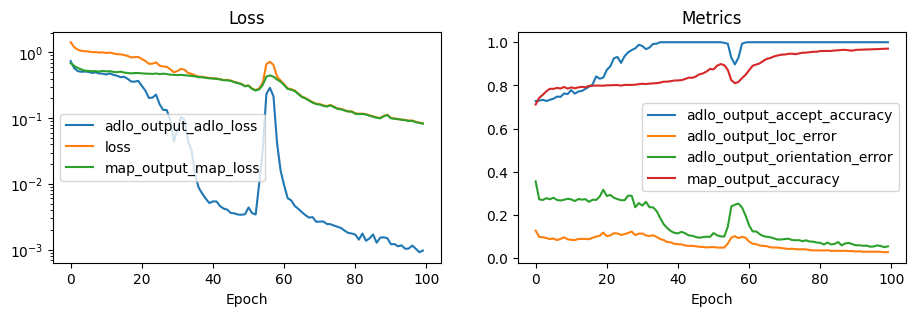

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
adlo:             [1. 0. 0. 0.]
adlo-pred raw:    [13.330573    0.02228769 -0.04088859 -0.05612926]
adlo-pred scaled: [ 0.99999833  0.011142   -0.02043291 -0.05607039]


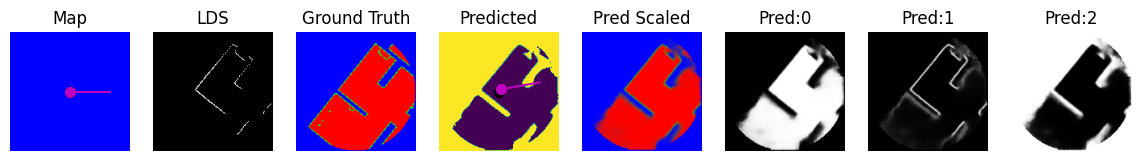

adlo:             [0. 0. 0. 0.]
adlo-pred raw:    [-9.1681299e+00 -1.2566624e-03  2.3669528e-02  3.0496053e-02]
adlo-pred scaled: [ 0.0001043  -0.00062833  0.01183255  0.0304866 ]


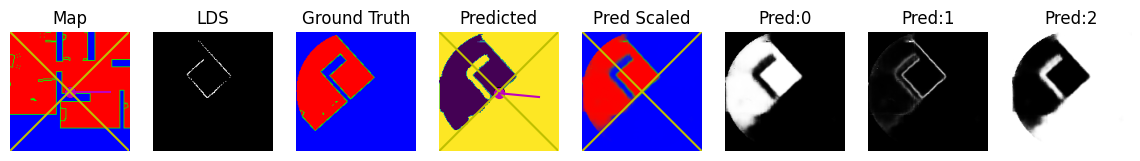

adlo:             [ 1.          0.33607876 -0.16260384  0.29634374]
adlo-pred raw:    [ 8.55104     0.619789   -0.32073426  0.27929944]
adlo-pred scaled: [ 0.9998067   0.27549055 -0.15508534  0.27225655]


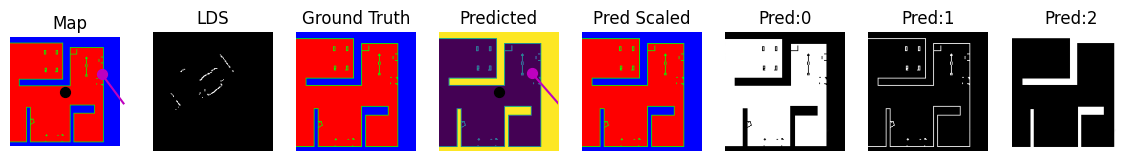

adlo:             [1. 0. 0. 0.]
adlo-pred raw:    [ 1.4381764e+01 -3.2851724e-03  1.6765865e-02 -4.7749326e-02]
adlo-pred scaled: [ 0.9999994  -0.00164258  0.00838215 -0.04771306]


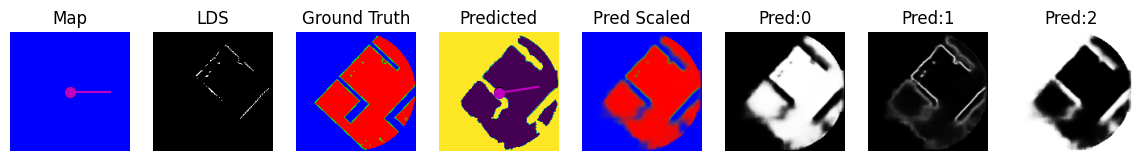

adlo:             [1.         0.17887953 0.22063265 0.16403958]
adlo-pred raw:    [11.046639    0.2228797   0.36013007  0.12133478]
adlo-pred scaled: [0.999984   0.10963051 0.1726643  0.12074281]


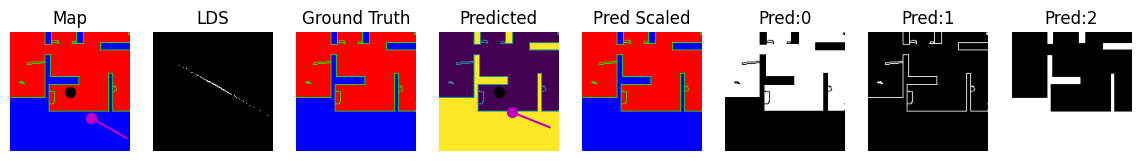

In [9]:
# Custom loss functions
# (out-of-the-box the two outputs get losses calculated independently,
#  ultimately I'll be wanting to conditionally choose whether the map loss
#  is considered depending on how the network is being used.
#  The easiest way to do that will be to generate the dataset so that the ground_truth_map
#  is blank for those cases)

def adlo_loss(y_true, y_pred):
    """
    y_true: (B,4), scaled
    y_pred: (B,4), logits
    """
    y_true = tf.cast(y_true, tf.float32)

    # binary cross-entropy loss for accept
    accept_true = y_true[:, 0]
    accept_pred = y_pred[:, 0]
    accept_losses = tf.keras.losses.binary_crossentropy(accept_true, accept_pred, from_logits=True)

    # log-cosh loss for delta x, y, orientation
    dlo_true = y_true[:, 1:4]
    delta_x = tf.math.tanh(y_pred[:, 1]) * 0.5  # -0.5 .. +0.5
    delta_y = tf.math.tanh(y_pred[:, 2]) * 0.5  # -0.5 .. +0.5
    delta_angle = tf.math.tanh(y_pred[:, 3])    # -1.0 .. +1.0
    dlo_pred = tf.stack([delta_x, delta_y, delta_angle], axis=1)
    dlo_losses = tf.reduce_mean(tf.math.log(tf.cosh(dlo_pred - dlo_true)))

    return accept_losses + dlo_losses

def accept_accuracy(y_true, y_pred):
    accept_true = tf.cast(y_true[:, 0], tf.float32)
    accept_pred = tf.cast(tf.round(tf.nn.sigmoid(y_pred[:, 0])), tf.float32)
    matches = tf.equal(accept_true, accept_pred)
    return tf.reduce_mean(tf.cast(matches, tf.float32))

def loc_error(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    loc_true = y_true[:, 1:3]
    loc_pred = tf.math.tanh(y_pred[:, 1:3]) * 0.5  # -0.5 .. +0.5
    losses = tf.math.sqrt(tf.keras.losses.MSE(loc_true, loc_pred))
    return tf.reduce_mean(losses)

def orientation_error(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    angle_true = y_true[:, 3]
    angle_pred = tf.math.tanh(y_pred[:, 3])  # -1.0 .. +1.0
    losses = tf.math.sqrt(tf.keras.losses.MSE(angle_true, angle_pred))
    return tf.reduce_mean(losses)

reload(slam)
reload(slam_data)
one = next(iter(train_data))
map_shape = one[0][0].shape
print(f"map_shape: {map_shape}")
np.random.seed(42)
tf.random.set_seed(42)

model = slam.slam_model(map_shape, conv_filters=32, adlo_units=256)
model.compile(optimizer='adam',
              #run_eagerly=True,
              loss={
                  'map_output': tf.keras.losses.CategoricalCrossentropy(from_logits=True),
                  'adlo_output': adlo_loss
              },
              metrics={
                  'map_output': [tf.keras.metrics.CategoricalCrossentropy(from_logits=True, name='map_loss'), 'accuracy'],
                  'adlo_output': [adlo_loss, accept_accuracy, loc_error, orientation_error]
              })

epochs = 100
batch_size = 32
model_train_data = train_data.shuffle(buffer_size=len(train_data)).batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)

start = timer()
model_history = model.fit(model_train_data, epochs=epochs)
duration = (timer() - start)
print(f"Epochs: {epochs}, duration: {duration} sec")
display_history(model_history)
slam_data.show_predictions(model, train_data, 5, show_classes='pred')